[Info] Data loaded and preprocessed: (2016, 5)


[Info] Features shape: (2004, 783)
[Info] Prophet/fallback fitted.
[Info] Clustering done. KMeans clusters: [0, 1, 2]
[Summary] {'total_points': 2016, 'anomalies_detected': 2016, 'by_rule': 7, 'by_model_residual': 23, 'by_cluster': 2016}


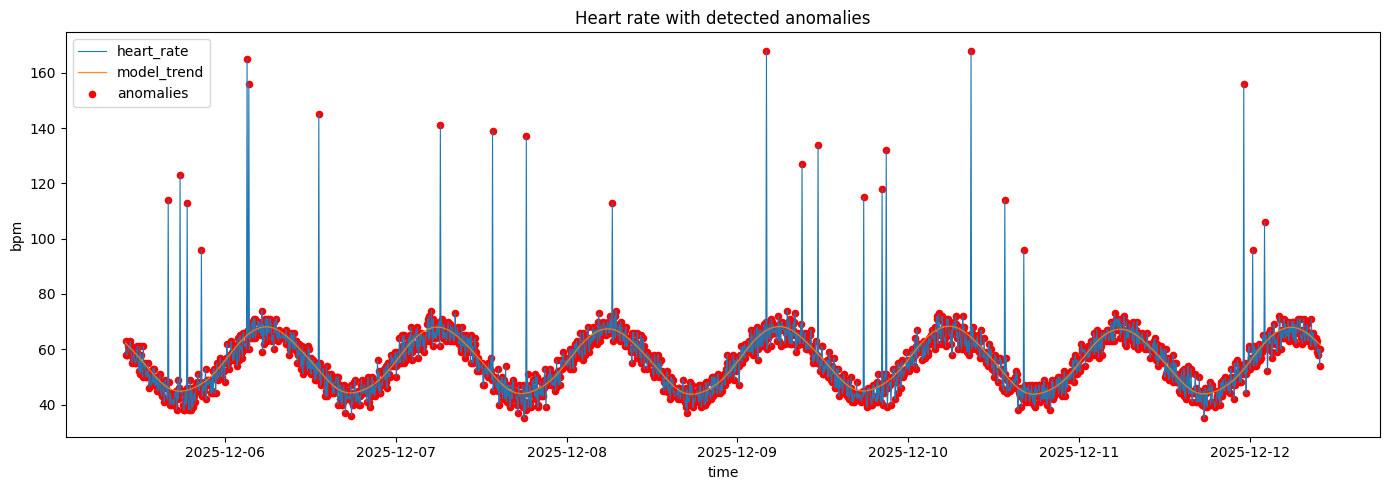


Top anomaly timestamps (sample):
                     heart_rate      _yhat  _residual
timestamp                                            
2025-12-05 10:00:00        63.0  62.244038   0.755962
2025-12-05 10:05:00        58.0  62.025854   4.025854
2025-12-05 10:10:00        58.0  61.806311   3.806311
2025-12-05 10:15:00        58.0  61.585460   3.585460
2025-12-05 10:20:00        59.0  61.363348   2.363348
2025-12-05 10:25:00        61.0  61.140015   0.140015
2025-12-05 10:30:00        60.0  60.915493   0.915493
2025-12-05 10:35:00        60.0  60.689810   0.689810
2025-12-05 10:40:00        63.0  60.462988   2.537012
2025-12-05 10:45:00        61.0  60.235044   0.764956

Outputs saved: milestone2_annotated_output.csv, milestone2_features.csv, milestone2_clustered_features.csv


In [7]:

"""
milestone2_pipeline.py

Feature Extraction & Modeling (Milestone 2)
- TSFresh-based feature extraction with a safe fallback
- Prophet-based trend modeling with a fallback to simple seasonal decomposition
- Clustering (KMeans + DBSCAN)
- Combined anomaly detection: thresholds, model residuals, cluster outliers
- Visualizations (matplotlib + optional plotly)
- Includes synthetic dataset generator so you can run it immediately

Requirements (recommended):
pip install pandas numpy matplotlib scikit-learn tsfresh prophet plotly
If tsfresh or prophet are missing, the script uses fallbacks and continues.

Run:
python milestone2_pipeline.py
"""

import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

# Optional libraries (import guarded)
try:
    from tsfresh import extract_features
    from tsfresh.utilities.dataframe_functions import impute
    TSFRESH_AVAILABLE = True
except Exception:
    TSFRESH_AVAILABLE = False

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False


def generate_synthetic_user_data(duration_days=14, freq_mins=5, seed=42):
    """
    Generates synthetic time-series data for heart rate, steps, and sleep-like signal.
    Returns DataFrame with columns: timestamp, heart_rate, steps, sleep_quality
    """
    np.random.seed(seed)
    start = datetime.now().replace(minute=0, second=0, microsecond=0) - timedelta(days=duration_days)
    idx = pd.date_range(start=start, periods=int(24*60/freq_mins*duration_days), freq=f"{freq_mins}T")
    df = pd.DataFrame({"timestamp": idx})
    # base heart rate: daily pattern + activity spikes + noise
    minutes = (df.timestamp - df.timestamp.dt.normalize()).dt.total_seconds() / 60.0
    daily_hr = 55 + 12*np.sin(2*np.pi*(minutes/1440))  # lower at night
    activity = (np.random.rand(len(df)) < 0.01).astype(int) * np.random.randint(40, 120, size=len(df))  # sparse spikes
    df["heart_rate"] = (daily_hr + activity + np.random.normal(0, 3, size=len(df))).round().astype(int)
    # steps accumulate in bursts: simulate walking episodes
    df["steps"] = (np.random.poisson(0.1, size=len(df)) * (np.random.rand(len(df)) < 0.03)).astype(int) * 10
    # sleep_quality proxy (higher during day bad, lower at night good)n
    df["sleep_quality"] = 100 - 20*np.cos(2*np.pi*(minutes/1440)) + np.random.normal(0, 5, size=len(df))
    # Insert some anomalies intentionally
    anom_idx = np.random.choice(len(df), size=max(3, int(len(df)*0.005)), replace=False)
    df.loc[anom_idx, "heart_rate"] = df.loc[anom_idx, "heart_rate"] + np.random.randint(40, 120, size=len(anom_idx))
    return df


def load_and_basic_preprocess(df):
    """
    Expect df with timestamp column. Returns clean df indexed by timestamp at uniform freq.
    """
    df = df.copy()
    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must have 'timestamp' column")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp").sort_index()
    # resample to 5min, forward-fill small gaps, interpolate larger
    df = df.resample("5T").mean()
    df = df.interpolate(limit=12).ffill().bfill()
    # add time features
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    return df


def _extract_fallback_rolling_features(df, column):
    """
    Helper function for fallback: rolling window statistical features.
    Returns a feature DataFrame with a DatetimeIndex.
    """
    window_length_in_5min_steps = 12 # 12 x 5min = 60 min
    rolls = df[column].rolling(window=window_length_in_5min_steps)

    feats = pd.DataFrame({
        "mean_hr_1h": rolls.mean(),
        "std_hr_1h": rolls.std(),
        "min_hr_1h": rolls.min(),
        "max_hr_1h": rolls.max(),
        "median_hr_1h": rolls.median(),
        "skew_hr_1h": rolls.apply(lambda x: x.skew() if len(x.dropna())>0 else np.nan)
    }, index=df.index)

    feats = feats.dropna()
    return feats


def extract_features_tsfresh_or_fallback(df, column="heart_rate", id_col="id"):
    """
    Try TSFresh to extract time-series features using rolling windows.
    If not available, compute manual aggregations per rolling windows.
    Returns a feature DataFrame (one row per window) with a DatetimeIndex.
    """
    # Define windowing parameters, similar to the fallback for consistency
    window_size_td = pd.Timedelta("60T") # 1 hour
    step_size_td = pd.Timedelta("5T") # 5 minutes

    if TSFRESH_AVAILABLE:
        window_data = []
        current_time = df.index.min()
        end_time = df.index.max()

        while current_time + window_size_td <= end_time:
            window_start = current_time
            # Use exclusive end for slicing to avoid duplicating the last point if window_end is current_time + window_size
            window_end = current_time + window_size_td - pd.Timedelta('1ns')

            window_df_subset = df.loc[window_start : window_end].copy()

            # Require a minimum number of data points for a meaningful window for tsfresh
            if len(window_df_subset) >= 5: # Assuming 5-min frequency, a 60min window has 12 points.
                temp_df = window_df_subset[[column]].reset_index().rename(columns={"timestamp": "time", column: "value"})
                temp_df[id_col] = current_time # Use window start time as ID
                window_data.append(temp_df)

            current_time += step_size_td

        if not window_data:
            print("[Warning] Not enough data to create tsfresh rolling windows. Falling back to simple rolling stats.")
            return _extract_fallback_rolling_features(df, column)

        full_long_df = pd.concat(window_data, ignore_index=True)
        full_long_df["time"] = (full_long_df["time"].astype("int64") // 10**9).astype(int)

        feats = extract_features(full_long_df, column_id=id_col, column_sort="time", disable_progressbar=True)
        impute(feats)

        # Set the index to the window start time for consistency
        feats.index = pd.to_datetime(feats.index.values, unit='ns')
        return feats

    else:
        return _extract_fallback_rolling_features(df, column)


def fit_prophet_or_fallback(df, column="heart_rate"):
    """
    Fit Prophet to the heart rate series when available. Return the model and a DataFrame with predicted trend.
    Fallback: simple moving-average + hourly seasonal decomposition (sin/cos).
    """
    ts = df[[column]].reset_index().rename(columns={"timestamp": "ds", column: "y"})
    if PROPHET_AVAILABLE:
        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
        m.fit(ts)
        future = m.make_future_dataframe(periods=0, freq="5T")
        forecast = m.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]].set_index("ds")
        return {"model": m, "forecast": forecast}
    else:
        # fallback trend: rolling median + sin/cos hour-seasonality
        ts = ts.set_index("ds")
        trend = ts[column].rolling(window=288, min_periods=12).median()  # 24h if 5-min -> 288 points
        hour = ts.index.hour + ts.index.minute/60.0
        seasonal = 6*np.sin(2*np.pi*hour/24)  # smooth daily waveform
        forecast = pd.DataFrame(index=ts.index)
        forecast["yhat"] = trend + seasonal
        return {"model": None, "forecast": forecast}


def cluster_behavior(features, n_kmeans=3, dbscan_eps=0.5, dbscan_min_samples=5):
    """
    Standardize features, run KMeans (coarse grouping) and DBSCAN (density-based outliers).
    Returns features with added cluster labels and outlier flags.
    """
    feats = features.copy().dropna()
    numeric = feats.select_dtypes(include=[np.number])

    # Handle cases where there are not enough samples for meaningful clustering/PCA
    if numeric.shape[0] < 2: # Need at least 2 samples for clustering/PCA
        print(f"[Warning] Not enough samples ({numeric.shape[0]}) for clustering. Skipping clustering.")
        result = features.copy()
        result["_kmeans_cluster"] = -1 # Indicate no cluster
        result["_dbscan_label"] = -1 # Indicate no label/outlier by default
        result["_outlier_dbscan"] = True # Mark as outlier if clustering cannot be performed
        return result, {}

    scaler = StandardScaler()
    X = scaler.fit_transform(numeric)

    Xp = X # Default to original scaled features
    # PCA for visualization stability if many features, and if enough samples
    if X.shape[1] > 6 and X.shape[0] > 1: # Ensure n_samples > 1 for PCA
        # n_components must be <= min(n_samples - 1, n_features)
        n_components_for_pca = min(6, X.shape[1], X.shape[0] - 1)
        if n_components_for_pca > 0: # Ensure we are asking for at least 1 component
            pca = PCA(n_components=n_components_for_pca)
            Xp = pca.fit_transform(X)
        else:
            print("[Warning] PCA skipped due to insufficient effective components (n_samples-1 or features).")

    # KMeans
    # Ensure n_clusters is <= number of samples
    n_clusters_kmeans = min(n_kmeans, max(1, Xp.shape[0]))
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0, n_init='auto')
    klabels = kmeans.fit_predict(Xp)

    # DBSCAN
    # Ensure min_samples is <= number of samples
    dbscan_min_samples_actual = min(dbscan_min_samples, max(1, Xp.shape[0]))
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples_actual)
    dlabels = db.fit_predict(Xp)  # -1 means noise/outlier
    outlier_flag = (dlabels == -1)
    result = feats.copy() # Use original feats index
    result["_kmeans_cluster"] = klabels
    result["_dbscan_label"] = dlabels
    result["_outlier_dbscan"] = outlier_flag
    return result, {"kmeans": kmeans, "dbscan": db, "scaler": scaler}


def detect_anomalies(df, forecast, features_with_clusters, hr_col="heart_rate",
                     hr_threshold_high=140, hr_threshold_low=35):
    """
    Combine multiple anomaly signals:
    - Rule-based threshold for heart rate
    - Model residuals: abs(y - yhat) > 3*std_of_residuals
    - Cluster outlier flags from DBSCAN
    Returns df with anomaly flags and a summary.
    """
    df = df.copy()
    # align forecast to df index
    forecast = forecast.reindex(df.index).fillna(method="ffill").fillna(method="bfill")
    df["_yhat"] = forecast["yhat"].values
    df["_residual"] = (df[hr_col] - df["_yhat"]).abs()
    resid_std = df["_residual"].std()
    df["_anom_threshold_model"] = df["_residual"] > (3 * max(1.0, resid_std))
    # rule-based
    df["_anom_threshold_rule"] = (df[hr_col] > hr_threshold_high) | (df[hr_col] < hr_threshold_low)
    # cluster-based: map features index back to timestamps if possible (fallback: mark where rolling stats are extreme)
    # The 'features_with_clusters' DataFrame now has a DatetimeIndex corresponding to window start times.
    # We need to map these back to the original df's timestamps.
    # A simple way is to use `reindex` with `method='nearest'` or `ffill`/`bfill`
    cluster_anom_mapped = pd.Series(False, index=df.index)
    if "_outlier_dbscan" in features_with_clusters.columns:
        # Reindex features_with_clusters to df's index
        # This will align each df timestamp to the nearest feature window start time
        temp_cluster_anom = features_with_clusters["_outlier_dbscan"].reindex(df.index, method='nearest', fill_value=False)
        cluster_anom_mapped = temp_cluster_anom
    else:
        # fallback if clustering was skipped or failed in cluster_behavior
        iso = IsolationForest(contamination=0.01, random_state=0)
        numeric = df[[hr_col, "hour", "dayofweek"]].fillna(method="ffill")
        iso_labels = iso.fit_predict(numeric)
        cluster_anom_mapped = pd.Series(iso_labels == -1, index=df.index)

    df["_anom_cluster"] = cluster_anom_mapped

    # Combine
    df["anomaly_combined"] = df[["_anom_threshold_model", "_anom_threshold_rule", "_anom_cluster"]].any(axis=1)
    summary = {
        "total_points": len(df),
        "anomalies_detected": int(df["anomaly_combined"].sum()),
        "by_rule": int(df["_anom_threshold_rule"].sum()),
        "by_model_residual": int(df["_anom_threshold_model"].sum()),
        "by_cluster": int(df["_anom_cluster"].sum())
    }
    return df, summary


def plot_summary(df, column="heart_rate"):
    """
    Matplotlib plot: timeseries, yhat, and anomaly markers
    """
    plt.figure(figsize=(14,5))
    plt.plot(df.index, df[column], label="heart_rate", linewidth=0.8)
    if "_yhat" in df.columns:
        plt.plot(df.index, df["_yhat"], label="model_trend", linewidth=0.9, alpha=0.9)
    anomalies = df[df["anomaly_combined"]]
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[column], color="red", label="anomalies", s=20)
    plt.legend()
    plt.title("Heart rate with detected anomalies")
    plt.xlabel("time")
    plt.ylabel("bpm")
    plt.tight_layout()
    plt.show()


def run_pipeline_with_synthetic_data():
    raw = generate_synthetic_user_data(duration_days=7)
    df = load_and_basic_preprocess(raw)
    print("[Info] Data loaded and preprocessed:", df.shape)

    # The id_col is internally handled within extract_features_tsfresh_or_fallback
    feats = extract_features_tsfresh_or_fallback(df, column="heart_rate")
    print("[Info] Features shape:", feats.shape)

    prophet_res = fit_prophet_or_fallback(df, column="heart_rate")
    print("[Info] Prophet/fallback fitted.")

    clustered_feats, cluster_models = cluster_behavior(feats, n_kmeans=3, dbscan_eps=0.6, dbscan_min_samples=4)
    if "_kmeans_cluster" in clustered_feats.columns:
        print("[Info] Clustering done. KMeans clusters:", np.unique(clustered_feats["_kmeans_cluster"]).tolist())
    else:
        print("[Info] Clustering skipped or failed.")

    annotated_df, summary = detect_anomalies(df, prophet_res["forecast"], clustered_feats, hr_threshold_high=140)
    print("[Summary]", summary)

    plot_summary(annotated_df, "heart_rate")
    return annotated_df, feats, clustered_feats, prophet_res, summary


if __name__ == "__main__":
    annotated_df, feats, clustered_feats, prophet_res, summary = run_pipeline_with_synthetic_data()
    # Save summary and sample anomalies
    print("\nTop anomaly timestamps (sample):")
    # Ensure 'anomaly_combined' exists and there are anomalies before trying to print
    if "anomaly_combined" in annotated_df.columns and not annotated_df[annotated_df["anomaly_combined"]].empty:
        print(annotated_df[annotated_df["anomaly_combined"]].head(10)[["heart_rate", "_yhat", "_residual"]])
    else:
        print("No anomalies detected or 'anomaly_combined' column is missing.")

    # Optionally save to CSV
    annotated_df.to_csv("milestone2_annotated_output.csv")
    feats.to_csv("milestone2_features.csv")
    clustered_feats.to_csv("milestone2_clustered_features.csv")
    print("\nOutputs saved: milestone2_annotated_output.csv, milestone2_features.csv, milestone2_clustered_features.csv")


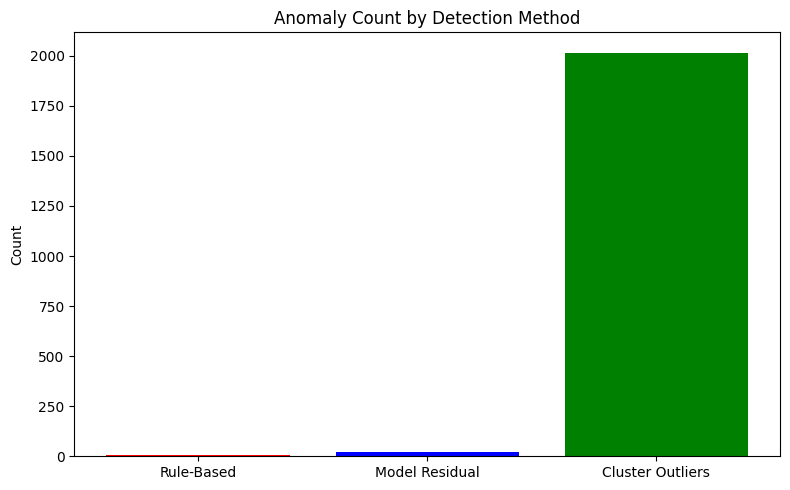

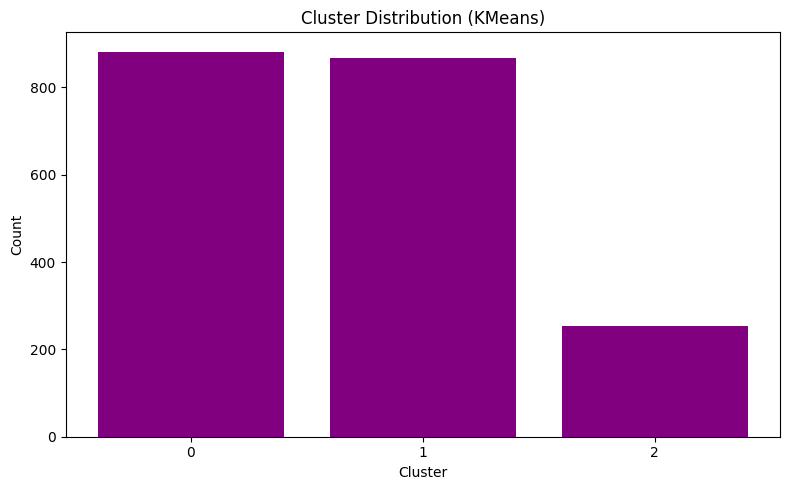

In [26]:
def plot_line_graphs(df):
    plt.figure(figsize=(14,5))
    plt.plot(df.index, df["heart_rate"], label="Heart Rate", linewidth=1)
    plt.plot(df.index, df["_yhat"], label="Forecast / Trend", linewidth=1)
    plt.title("Heart Rate vs Trend")
    plt.xlabel("Time")
    plt.ylabel("Heart Rate (bpm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual line graph
    plt.figure(figsize=(14,5))
    plt.plot(df.index, df["_residual"], label="Residuals", color="orange", linewidth=1)
    plt.title("Residual Error Over Time")
    plt.xlabel("Time")
    plt.ylabel("Residual")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plot_line_graphs(annotated_df)
plot_bar_graphs(summary, clustered_feats)









In [28]:
def plot_bar_graphs(summary, clustered_feats):
    # Summary bar chart
    labels = ["Rule-Based", "Model Residual", "Cluster Outliers"]
    values = [
        summary["by_rule"],
        summary["by_model_residual"],
        summary["by_cluster"]
    ]

    plt.figure(figsize=(8,5))
    plt.bar(labels, values, color=["red", "blue", "green"])
    plt.title("Anomaly Count by Detection Method")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Cluster distribution bar chart
    if "_kmeans_cluster" in clustered_feats.columns:
        cluster_counts = clustered_feats["_kmeans_cluster"].value_counts().sort_index()
        plt.figure(figsize=(8,5))
        plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="purple")
        plt.title("Cluster Distribution (KMeans)")
        plt.xlabel("Cluster")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
        plot_line_graphs(annotated_df)
        plot_bar_graphs(summary, clustered_feats)
